In [68]:
import json
import os

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

import httpx
from tqdm import tqdm
from loguru import logger
from dotenv import load_dotenv
load_dotenv()

sns.set_theme(style="whitegrid")

In [ ]:
def read_json(path):
    with open(path) as f:
        return json.load(f)


### Include Spam

In [ ]:
tokens = read_json('./data/tokens.json')
logger.info(f"contract count: {len(set([token["token"]["contract"] for token in tokens]))}")
logger.info(f"token count: {len(set([token["token"]["tokenId"] for token in tokens]))}")

### Exclude Spam

In [100]:
tokens = read_json('./data/tokens_exclude_spams.json')
logger.info(f"contract count: {len(set([token["token"]["contract"] for token in tokens]))}")
logger.info(f"token count: {len(set([token["token"]["tokenId"] for token in tokens]))}")

2023-12-05 13:23:16.139 | INFO     | __main__:<module>:2 - contract count: 55
2023-12-05 13:23:16.140 | INFO     | __main__:<module>:3 - token count: 1919


### Make DataFrame

In [101]:
pl_list = []

for token in tokens:
    
    token_info = {
        "contract": token["token"]["contract"],
        "token_id": token["token"]["tokenId"],
        "token_name": token["token"]["name"],
        "token_kind": token["token"]["kind"],
        "floorprice": token["token"]["collection"]["floorAskPrice"]["amount"]["usd"] if token["token"]["collection"]["floorAskPrice"] else None,
        "last_appraisal_value": token["token"]["lastAppraisalValue"],
        "token_count": int(token["ownership"]["tokenCount"]),
        "on_sale_count": int(token["ownership"]["onSaleCount"]),
        "acquired_at": token["ownership"]["acquiredAt"],
    }
    
    # logger.info(token_info)
    pl_list.append(token_info)

df = pl.DataFrame(data=pl_list)
df

contract,token_id,token_name,token_kind,floorprice,last_appraisal_value,token_count,on_sale_count,acquired_at
str,str,str,str,f64,f64,i64,i64,str
"""0x57f1887a8bf1…","""87691055622945…","""memecoin.eth""","""erc721""",2.1907,42.069,1,0,"""2023-11-27T06:…"
"""0x60c9b34c92e0…","""7""","""Introducing: B…","""erc721""",null,null,1,0,"""2023-11-23T09:…"
"""0x60c9b34c92e0…","""6""","""Introducing: B…","""erc721""",null,null,1,0,"""2023-11-23T09:…"
"""0x67f4797d84ac…","""1""","""Visit apyape.o…","""erc1155""",null,null,1,0,"""2023-11-18T22:…"
"""0xdda0e9bc9b34…","""1""","""Golden Tickets…","""erc1155""",151.15858,null,1,1,"""2023-11-05T12:…"
"""0x372a04d2a635…","""2""","""Captianz #1007…","""erc1155""",7163.60221,null,1,1,"""2023-11-04T17:…"
"""0x3f62e545b1f5…","""1""","""Po͏t͏a͏t͏o͏z #…","""erc1155""",null,null,1,0,"""2023-11-02T22:…"
"""0x6a82a05b7ff8…","""0""",null,"""erc1155""",null,null,1,0,"""2023-10-27T05:…"
"""0xd4416b13d2b3…","""11486569652741…","""memefoundation…","""erc1155""",4.38141,null,1,0,"""2023-10-20T12:…"


### Analyze

In [91]:
df.filter(pl.col("on_sale_count") > 0)

contract,token_id,token_name,token_kind,floorprice,token_count,on_sale_count,acquired_at
str,str,str,str,f64,i64,i64,str
"""0xdda0e9bc9b34…","""1""","""Golden Tickets…","""erc1155""",151.15858,1,1,"""2023-11-05T12:…"
"""0x372a04d2a635…","""2""","""Captianz #1007…","""erc1155""",7163.60221,1,1,"""2023-11-04T17:…"
"""0x495f94727674…","""79175504051762…","""Compromised Li…","""erc1155""",13801.43545,1,1,"""2023-07-29T10:…"
"""0x495f94727674…","""94686434302712…","""MVP #0""","""erc1155""",28479.15252,1,1,"""2023-06-16T11:…"
"""0x091fc2e2bb98…","""1""","""House of Lee: …","""erc1155""",3.50513,1127,1,"""2023-04-13T19:…"
"""0x495f94727674…","""13951738445175…","""Banksy's Punk …","""erc1155""",1073.44498,1,1,"""2023-01-07T07:…"
"""0xb66a603f4cfe…","""11813982658165…","""Воrеd Аре Yасh…","""erc1155""",0.01533,1,1,"""2023-01-02T22:…"
"""0x495f94727674…","""13951738445175…","""Twitter Conqui…","""erc1155""",635.30417,1,1,"""2022-12-02T06:…"
"""0x495f94727674…","""13951738445175…","""Queen Elizabet…","""erc1155""",635.30417,1,1,"""2022-09-10T05:…"


<Axes: xlabel='on_sale_count', ylabel='Count'>

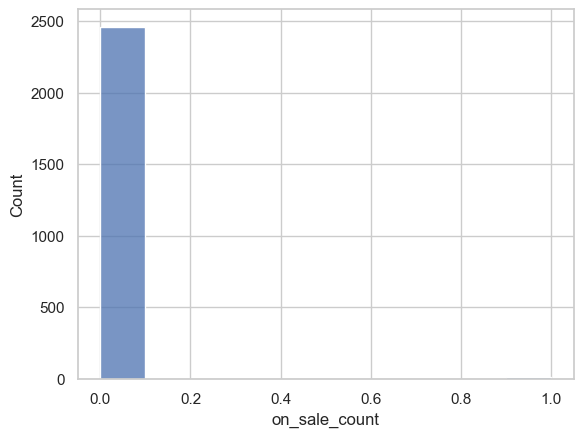

In [69]:
sns.histplot(df, x="on_sale_count", bins=10)

In [90]:
df.filter(pl.col("token_count") > 0).sort(by="token_count", descending=True)

contract,token_id,token_name,token_kind,floorprice,token_count,on_sale_count,acquired_at
str,str,str,str,f64,i64,i64,str
"""0x091fc2e2bb98…","""1""","""House of Lee: …","""erc1155""",3.50513,1127,1,"""2023-04-13T19:…"
"""0x495f94727674…","""56044906628959…","""MEMELAND 🌱 VIP…","""erc1155""",1.75256,22,0,"""2022-07-21T18:…"
"""0x495f94727674…","""10939727539745…","""Potatoez #1213…","""erc1155""",1.75256,9,0,"""2022-07-23T12:…"
"""0x495f94727674…","""10939727539745…","""Modernist Mask…","""erc1155""",1.75256,3,0,"""2022-08-01T00:…"
"""0x495f94727674…","""19304791136201…","""Bored Ape Alte…","""erc1155""",1.75256,2,0,"""2022-08-13T08:…"
"""0x495f94727674…","""19910237642144…","""#0 [Legendary …","""erc1155""",1.75256,2,0,"""2022-07-21T15:…"
"""0x57f1887a8bf1…","""87691055622945…","""memecoin.eth""","""erc721""",2.1907,1,0,"""2023-11-27T06:…"
"""0x60c9b34c92e0…","""7""","""Introducing: B…","""erc721""",null,1,0,"""2023-11-23T09:…"
"""0x60c9b34c92e0…","""6""","""Introducing: B…","""erc721""",null,1,0,"""2023-11-23T09:…"


In [99]:
df.filter(pl.col("token_count") > 1)

contract,token_id,token_name,token_kind,floorprice,last_appraisal_value,token_count,on_sale_count,acquired_at
str,str,str,str,f64,f64,i64,i64,str
"""0x091fc2e2bb98…","""1""","""House of Lee: …","""erc1155""",3.50513,null,1127,1,"""2023-04-13T19:…"
"""0x495f94727674…","""19304791136201…","""Bored Ape Alte…","""erc1155""",1.75256,0.028,2,0,"""2022-08-13T08:…"
"""0x495f94727674…","""10939727539745…","""Modernist Mask…","""erc1155""",1.75256,null,3,0,"""2022-08-01T00:…"
"""0x495f94727674…","""10939727539745…","""Potatoez #1213…","""erc1155""",1.75256,null,9,0,"""2022-07-23T12:…"
"""0x495f94727674…","""56044906628959…","""MEMELAND 🌱 VIP…","""erc1155""",1.75256,null,22,0,"""2022-07-21T18:…"
"""0x495f94727674…","""19910237642144…","""#0 [Legendary …","""erc1155""",1.75256,null,2,0,"""2022-07-21T15:…"


In [64]:
df.filter(pl.col("floorprice") > 0).sort(by="floorprice", descending=True)

contract,token_id,token_name,token_kind,floorprice,token_count,on_sale_count
str,str,str,str,f64,i64,i64
"""0x6efc003d3f36…","""275""","""MVP #275""","""erc721""",151158.57876,1,0
"""0x6efc003d3f36…","""406""","""MVP #406""","""erc721""",151158.57876,1,0
"""0x6efc003d3f36…","""419""","""MVP #419""","""erc721""",151158.57876,1,0
"""0x6efc003d3f36…","""414""","""MVP #414""","""erc721""",151158.57876,1,0
"""0x6efc003d3f36…","""413""","""MVP #413""","""erc721""",151158.57876,1,0
"""0x6efc003d3f36…","""410""","""MVP #410""","""erc721""",151158.57876,1,0
"""0x6efc003d3f36…","""409""","""MVP #409""","""erc721""",151158.57876,1,0
"""0x6efc003d3f36…","""407""","""MVP #407""","""erc721""",151158.57876,1,0
"""0x6efc003d3f36…","""405""","""MVP #405""","""erc721""",151158.57876,1,0


<Axes: xlabel='floorprice', ylabel='Count'>

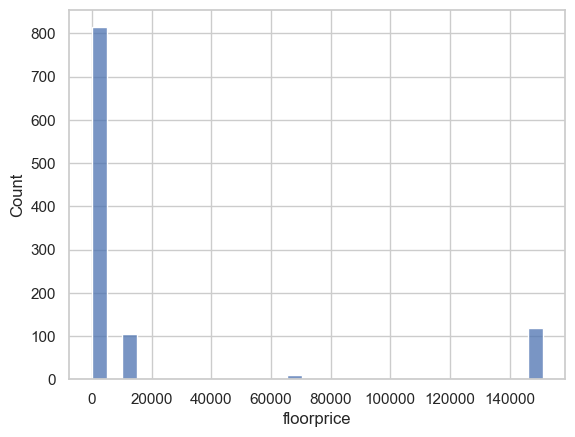

In [71]:
sns.histplot(df, x="floorprice", bins=30)

In [92]:
df.filter(pl.col("floorprice") > 100000).sort(by="floorprice", descending=True)

contract,token_id,token_name,token_kind,floorprice,token_count,on_sale_count,acquired_at
str,str,str,str,f64,i64,i64,str
"""0x6efc003d3f36…","""275""","""MVP #275""","""erc721""",151158.57876,1,0,"""2023-05-22T18:…"
"""0x6efc003d3f36…","""406""","""MVP #406""","""erc721""",151158.57876,1,0,"""2023-01-02T17:…"
"""0x6efc003d3f36…","""419""","""MVP #419""","""erc721""",151158.57876,1,0,"""2022-06-16T13:…"
"""0x6efc003d3f36…","""414""","""MVP #414""","""erc721""",151158.57876,1,0,"""2022-06-16T13:…"
"""0x6efc003d3f36…","""413""","""MVP #413""","""erc721""",151158.57876,1,0,"""2022-06-16T13:…"
"""0x6efc003d3f36…","""410""","""MVP #410""","""erc721""",151158.57876,1,0,"""2022-06-16T13:…"
"""0x6efc003d3f36…","""409""","""MVP #409""","""erc721""",151158.57876,1,0,"""2022-06-16T13:…"
"""0x6efc003d3f36…","""407""","""MVP #407""","""erc721""",151158.57876,1,0,"""2022-06-16T13:…"
"""0x6efc003d3f36…","""405""","""MVP #405""","""erc721""",151158.57876,1,0,"""2022-06-16T13:…"


In [95]:
df.filter(pl.col("token_name").str.contains("MVP #"))

contract,token_id,token_name,token_kind,floorprice,token_count,on_sale_count,acquired_at
str,str,str,str,f64,i64,i64,str
"""0x495f94727674…","""94686434302712…","""MVP #0""","""erc1155""",28479.15252,1,1,"""2023-06-16T11:…"
"""0x6efc003d3f36…","""275""","""MVP #275""","""erc721""",151158.57876,1,0,"""2023-05-22T18:…"
"""0x6efc003d3f36…","""406""","""MVP #406""","""erc721""",151158.57876,1,0,"""2023-01-02T17:…"
"""0x495f94727674…","""56044906628959…","""MVP #147""","""erc1155""",1.75256,1,0,"""2022-08-20T09:…"
"""0x495f94727674…","""10998846539750…","""(Legendary) MV…","""erc1155""",1.75256,1,0,"""2022-08-18T13:…"
"""0x495f94727674…","""10998846539750…","""(Legendary) MV…","""erc1155""",1.75256,1,0,"""2022-08-08T09:…"
"""0x495f94727674…","""10998846539750…","""(Legendary) MV…","""erc1155""",1.75256,1,0,"""2022-08-04T18:…"
"""0x495f94727674…","""10998846539750…","""(Legendary) MV…","""erc1155""",1.75256,1,0,"""2022-08-04T14:…"
"""0x495f94727674…","""10998846539750…","""(Legendary) MV…","""erc1155""",1.75256,1,0,"""2022-08-02T08:…"


In [88]:
df.filter(pl.col("floorprice") < 100000, pl.col("floorprice") > 10000).sort(by="floorprice", descending=True)

contract,token_id,token_name,token_kind,floorprice,token_count,on_sale_count
str,str,str,str,f64,i64,i64
"""0xbc4ca0eda764…","""4851""",null,"""erc721""",65940.1916,1,0
"""0xbc4ca0eda764…","""9689""",null,"""erc721""",65940.1916,1,0
"""0xbc4ca0eda764…","""9299""",null,"""erc721""",65940.1916,1,0
"""0xbc4ca0eda764…","""9286""",null,"""erc721""",65940.1916,1,0
"""0xbc4ca0eda764…","""8293""",null,"""erc721""",65940.1916,1,0
"""0xbc4ca0eda764…","""4673""",null,"""erc721""",65940.1916,1,0
"""0xbc4ca0eda764…","""4024""",null,"""erc721""",65940.1916,1,0
"""0xbc4ca0eda764…","""2929""",null,"""erc721""",65940.1916,1,0
"""0xbc4ca0eda764…","""2059""",null,"""erc721""",65940.1916,1,0


In [106]:
df.write_csv("./data/estimate.csv")

In [102]:
df_estimate = df.with_columns((pl.col("floorprice") * pl.col("token_count")).alias("estimate_price")).filter(pl.col("estimate_price") > 0).sort(by="estimate_price", descending=True)

In [108]:
df_estimate

contract,token_id,token_name,token_kind,floorprice,last_appraisal_value,token_count,on_sale_count,acquired_at,estimate_price
str,str,str,str,f64,f64,i64,i64,str,f64
"""0x6efc003d3f36…","""275""","""MVP #275""","""erc721""",151158.57876,null,1,0,"""2023-05-22T18:…",151158.57876
"""0x6efc003d3f36…","""406""","""MVP #406""","""erc721""",151158.57876,null,1,0,"""2023-01-02T17:…",151158.57876
"""0x6efc003d3f36…","""419""","""MVP #419""","""erc721""",151158.57876,null,1,0,"""2022-06-16T13:…",151158.57876
"""0x6efc003d3f36…","""414""","""MVP #414""","""erc721""",151158.57876,null,1,0,"""2022-06-16T13:…",151158.57876
"""0x6efc003d3f36…","""413""","""MVP #413""","""erc721""",151158.57876,null,1,0,"""2022-06-16T13:…",151158.57876
"""0x6efc003d3f36…","""410""","""MVP #410""","""erc721""",151158.57876,null,1,0,"""2022-06-16T13:…",151158.57876
"""0x6efc003d3f36…","""409""","""MVP #409""","""erc721""",151158.57876,null,1,0,"""2022-06-16T13:…",151158.57876
"""0x6efc003d3f36…","""407""","""MVP #407""","""erc721""",151158.57876,null,1,0,"""2022-06-16T13:…",151158.57876
"""0x6efc003d3f36…","""405""","""MVP #405""","""erc721""",151158.57876,null,1,0,"""2022-06-16T13:…",151158.57876


In [122]:
df_estimate.with_columns(
    pl.when(pl.col("last_appraisal_value").is_not_null())
    .then(pl.col("last_appraisal_value") * pl.col("token_count"))
    .otherwise(pl.col("estimate_price"))
    .alias("total_estimate_price")
).drop("estimate_price").write_csv("./data/estimate_v2.csv")

In [118]:
total_price = df_estimate.with_columns(
    pl.when(pl.col("last_appraisal_value").is_not_null())
    .then(pl.col("last_appraisal_value") * pl.col("token_count"))
    .otherwise(pl.col("estimate_price"))
    .alias("total_estimate_price")
).select("total_estimate_price")["total_estimate_price"].sum()

In [119]:
usd_to_krw = 1309.53
usd_to_eth = 0.00044561

total_price = df_estimate.with_columns(
    pl.when(pl.col("last_appraisal_value").is_not_null())
    .then(pl.col("last_appraisal_value") * pl.col("token_count"))
    .otherwise(pl.col("estimate_price"))
    .alias("total_estimate_price")
).select("total_estimate_price")["total_estimate_price"].sum()

In [120]:
total_price_krw = total_price * usd_to_krw
total_price_eth = total_price * usd_to_eth

logger.info(f"total_price: {total_price}")
logger.info(f"total_price_krw: {total_price_krw}")
logger.info(f"total_price_eth: {total_price_eth}")

2023-12-05 13:59:38.008 | INFO     | __main__:<module>:4 - total_price: 20391851.582769997
2023-12-05 13:59:38.009 | INFO     | __main__:<module>:5 - total_price_krw: 26703741403.184795
2023-12-05 13:59:38.010 | INFO     | __main__:<module>:6 - total_price_eth: 9086.812983798138
